In [13]:
import numpy as np
import matplotlib.pyplot as plt


In [14]:
def morph_sawtooth_triangle(t, morph):
    """
    Create a piecewise-linear waveform where the time p at which x==+1
    is determined by morph (p = morph). We do NOT blend saw and triangle
    amplitudes; instead we change the slopes so the peak time equals morph.

    For numerical stability, clamp p into (eps, 1-eps).

    Behavior:
      - t in [0, p]: linear rise from -1 to +1
      - t in (p, 1]: linear fall from +1 to -1

    morph in [0,1] maps directly to p (peak time).
    """
    t_norm = t - np.floor(t)

    # peak time equals morph, clamp to avoid division by zero
    eps = 1e-6
    p = np.clip(morph, eps, 1.0 - eps)

    # Rising segment: -1 -> +1 over [0, p]
    rise = -1 + (2.0 / p) * t_norm
    # Falling segment: +1 -> -1 over (p,1]
    fall = 1 + (-2.0 / (1.0 - p)) * (t_norm - p)

    triangle_like = np.where(t_norm <= p, rise, fall)
    return triangle_like



In [20]:
def morph_triangle_sin(t, morph, freq=1.0):
    """
    Crossfade between a triangle wave (morph=0 -> 100%) and a sine wave (morph=1 -> 100%).

    Inputs:
      - t: time (array-like), normalized so 1 period = 1. Can be >1 for multiple periods.
      - morph: 0..1, 0 => triangle only, 1 => sine only
      - freq: frequency in cycles per unit t (default 1)

    Output: waveform in range [-1, 1]
    """
    # normalize time to phase [0,1)
    t_norm = (t * freq) - np.floor(t * freq)

    # triangle: -1 at t=0, +1 at t=0.5, -1 at t=1
    tri = np.where(t_norm <= 0.5, -1 + 4 * t_norm, 3 - 4 * t_norm)

    # sine: use -cos for phase alignment (sine-like)
    sine = - np.cos(2 * np.pi * t * freq)

    # linear crossfade: morph=0 -> tri, morph=1 -> sine
    morph = np.clip(morph, 0.0, 1.0)
    out = (1.0 - morph) * tri + morph * sine
    return out



In [21]:

def morph_sin_square(t, morph, freq=1.0, duty=0.5):
    """
    Crossfade between a -cos wave (named "sin" for API) and a square wave.

    Inputs:
      - t: time (array-like)
      - morph: 0..1 (0 => -cos only, 1 => square only)
      - freq: frequency in cycles per unit t
      - duty: duty cycle for square wave (0..1), default 0.5 (ignored now)

    Output: waveform in [-1,1]
    """
    t_norm = (t * freq) - np.floor(t * freq)
    # -cos wave
    sine_like = - np.cos(2 * np.pi * t * freq)

    # square wave: +1 for 0.25 <= phase < 0.75, else -1
    square = np.where((t_norm >= 0.25) & (t_norm < 0.75), 1.0, -1.0)

    morph = np.clip(morph, 0.0, 1.0)
    out = (1.0 - morph) * sine_like + morph * square
    return out


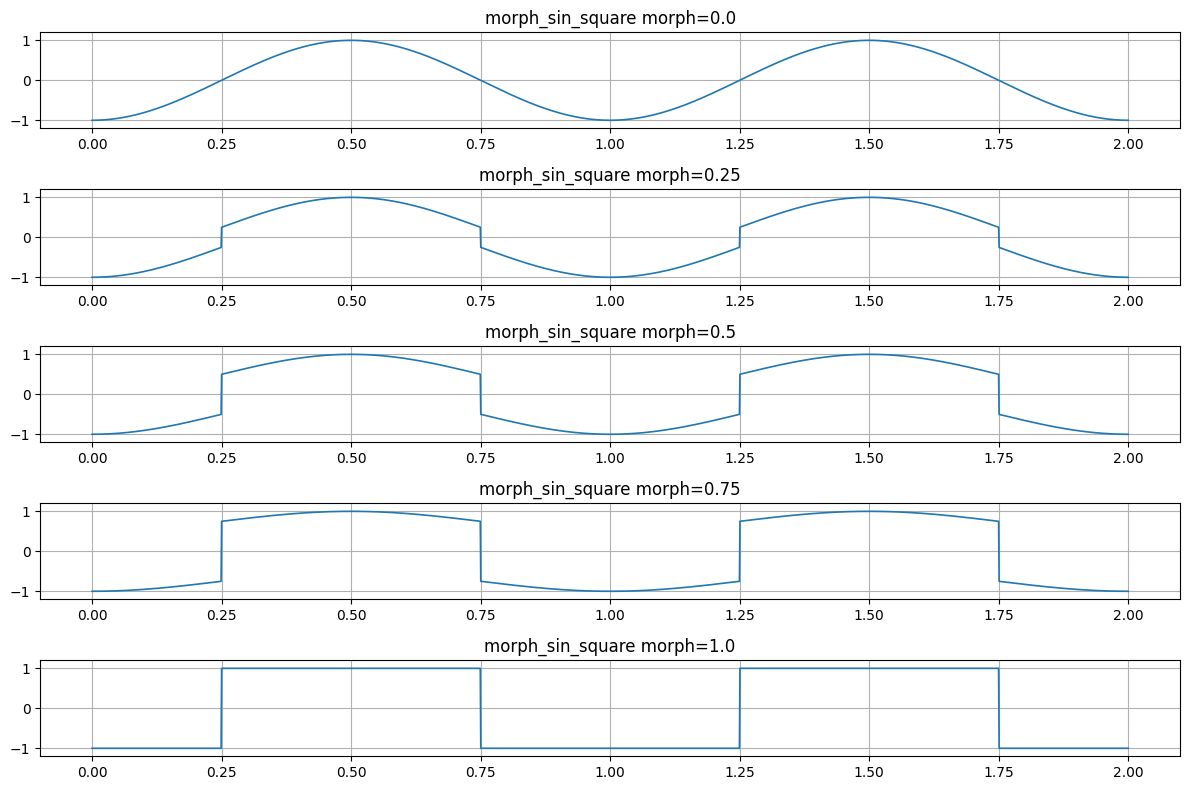

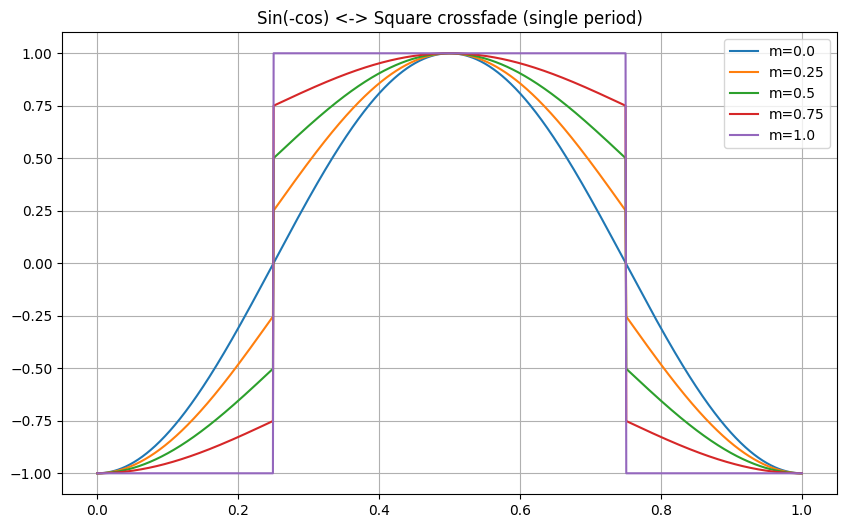

morph=0.0 -> [-1.0000000e+00 -6.1232340e-17  1.0000000e+00  1.8369702e-16]
morph=0.5 -> [-1.   0.5  1.  -0.5]
morph=1.0 -> [-1.  1.  1. -1.]


In [22]:

# 確認プロット
fs = 1000
t = np.linspace(0, 2, fs * 2)
vals = [0.0, 0.25, 0.5, 0.75, 1.0]
plt.figure(figsize=(12, 8))
for i, m in enumerate(vals):
    y = morph_sin_square(t, m)
    plt.subplot(len(vals), 1, i+1)
    plt.plot(t, y, linewidth=1.2)
    plt.title(f'morph_sin_square morph={m}')
    plt.ylim(-1.2, 1.2)
    plt.grid(True)

plt.tight_layout()
plt.show()

# 1周期重ね表示
t1 = np.linspace(0, 1, fs)
plt.figure(figsize=(10, 6))
for m in vals:
    plt.plot(t1, morph_sin_square(t1, m), label=f'm={m}')
plt.legend()
plt.title('Sin(-cos) <-> Square crossfade (single period)')
plt.grid(True)
plt.show()

# サンプル出力
for m in [0.0, 0.5, 1.0]:
    t_check = np.array([0.0, 0.25, 0.5, 0.75])
    print(f'morph={m} ->', morph_sin_square(t_check, m))

In [16]:

def morph_sin_square(t, morph, freq=1.0, duty=0.5):
    """
    Crossfade between a -cos wave (named "sin" for API) and a square wave.

    Inputs:
      - t: time (array-like)
      - morph: 0..1 (0 => -cos only, 1 => square only)
      - freq: frequency in cycles per unit t
      - duty: duty cycle for square wave (0..1), default 0.5

    Output: waveform in [-1,1]
    """
    t_norm = (t * freq) - np.floor(t * freq)
    # -cos wave
    sine_like = - np.cos(2 * np.pi * t * freq)

    # square wave: +1 for phase < duty, else -1
    square = np.where(t_norm < duty, 1.0, -1.0)

    morph = np.clip(morph, 0.0, 1.0)
    out = (1.0 - morph) * sine_like + morph * square
    return out


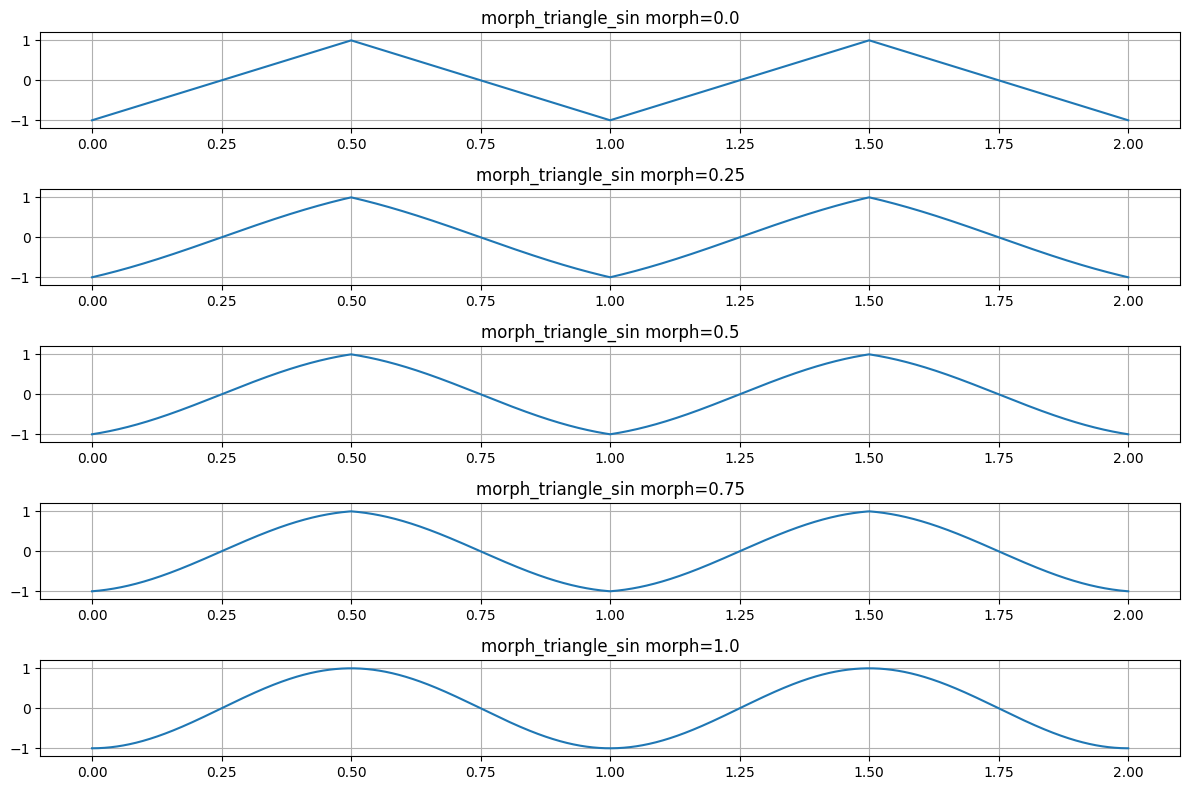

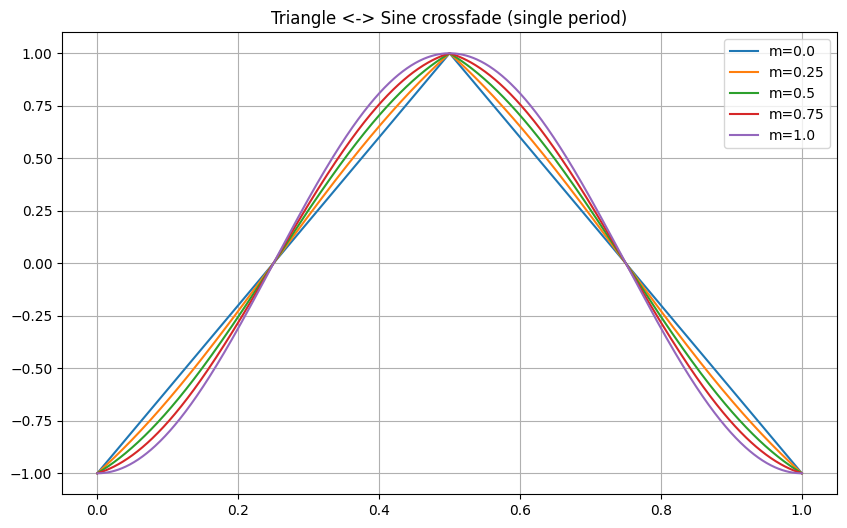

morph=0.0 -> [-1.  0.  1.  0.]
morph=0.5 -> [-1.00000000e+00 -3.06161700e-17  1.00000000e+00  9.18485099e-17]
morph=1.0 -> [-1.0000000e+00 -6.1232340e-17  1.0000000e+00  1.8369702e-16]


In [26]:

# いくつかのプロットで確認
fs = 1000
t = np.linspace(0, 2, fs * 2)
vals = [0.0, 0.25, 0.5, 0.75, 1.0]
plt.figure(figsize=(12, 8))
for i, m in enumerate(vals):
    y = morph_triangle_sin(t, m)
    plt.subplot(len(vals), 1, i+1)
    plt.plot(t, y, linewidth=1.5)
    plt.title(f'morph_triangle_sin morph={m}')
    plt.ylim(-1.2, 1.2)
    plt.grid(True)

plt.tight_layout()
plt.show()

# 1周期で重ねて表示
t1 = np.linspace(0, 1, fs)
plt.figure(figsize=(10, 6))
for m in vals:
    plt.plot(t1, morph_triangle_sin(t1, m), label=f'm={m}')
plt.legend()
plt.title('Triangle <-> Sine crossfade (single period)')
plt.grid(True)
plt.show()

# 確認点を出力
for m in [0.0, 0.5, 1.0]:
    t_check = np.array([0.0, 0.25, 0.5, 0.75])
    print(f'morph={m} ->', morph_triangle_sin(t_check, m))

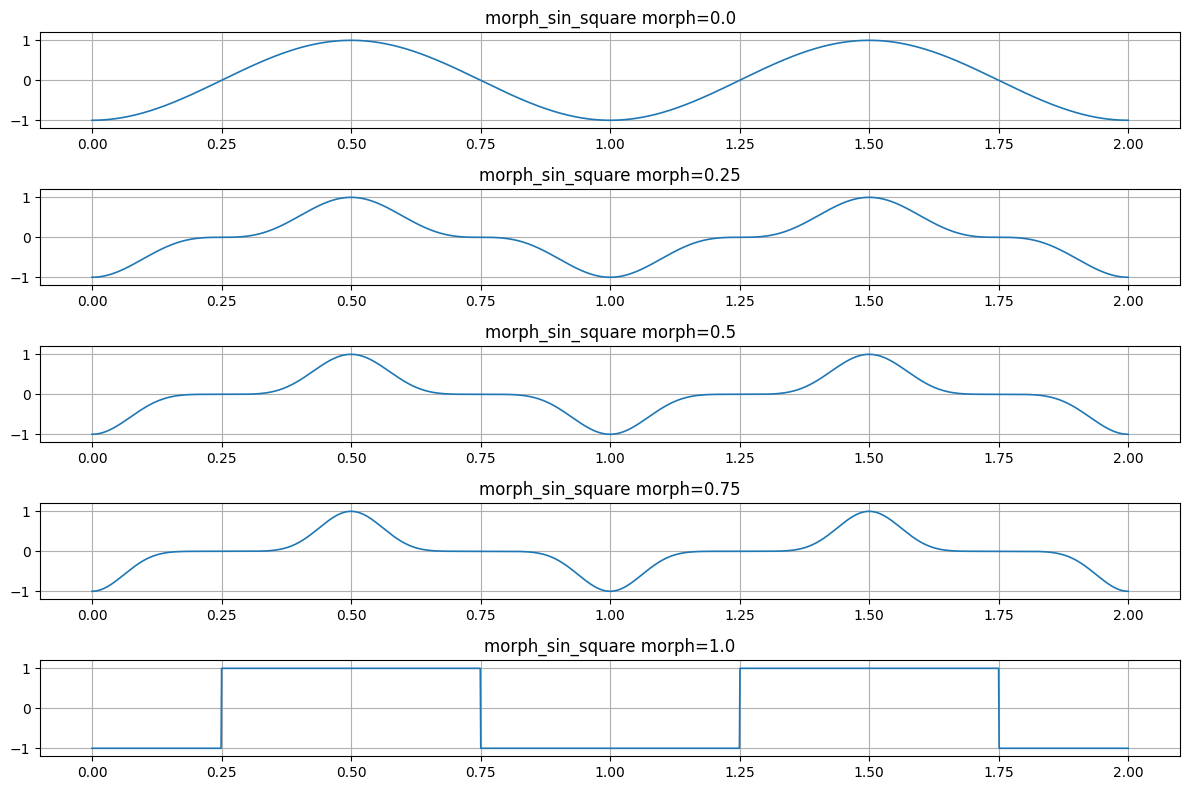

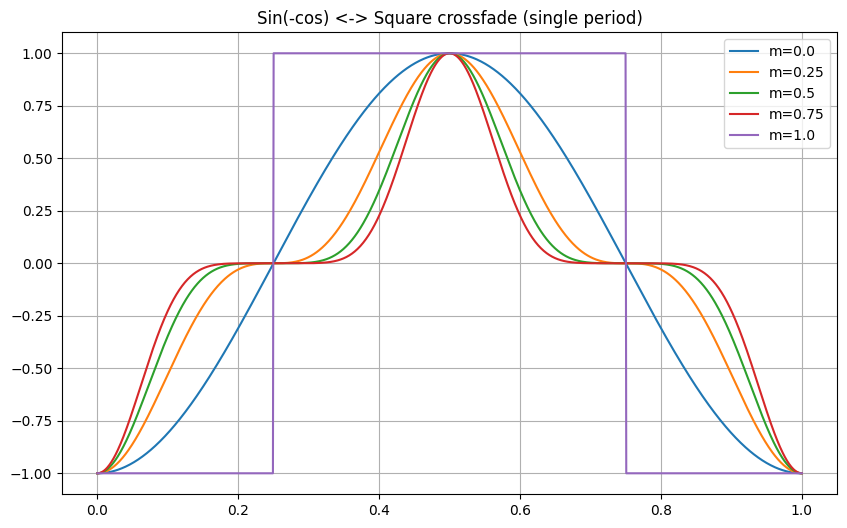

morph=0.0 -> [-1.0000000e+00 -6.1232340e-17  1.0000000e+00  1.8369702e-16]
morph=0.5 -> [-1.00000000e+00 -8.60804008e-82  1.00000000e+00  2.09175374e-79]
morph=1.0 -> [-1.  1.  1. -1.]


In [25]:

# 確認プロット
fs = 1000
t = np.linspace(0, 2, fs * 2)
vals = [0.0, 0.25, 0.5, 0.75, 1.0]
plt.figure(figsize=(12, 8))
for i, m in enumerate(vals):
    y = morph_sin_square(t, m)
    plt.subplot(len(vals), 1, i+1)
    plt.plot(t, y, linewidth=1.2)
    plt.title(f'morph_sin_square morph={m}')
    plt.ylim(-1.2, 1.2)
    plt.grid(True)

plt.tight_layout()
plt.show()

# 1周期重ね表示
t1 = np.linspace(0, 1, fs)
plt.figure(figsize=(10, 6))
for m in vals:
    plt.plot(t1, morph_sin_square(t1, m), label=f'm={m}')
plt.legend()
plt.title('Sin(-cos) <-> Square crossfade (single period)')
plt.grid(True)
plt.show()

# サンプル出力
for m in [0.0, 0.5, 1.0]:
    t_check = np.array([0.0, 0.25, 0.5, 0.75])
    print(f'morph={m} ->', morph_sin_square(t_check, m))

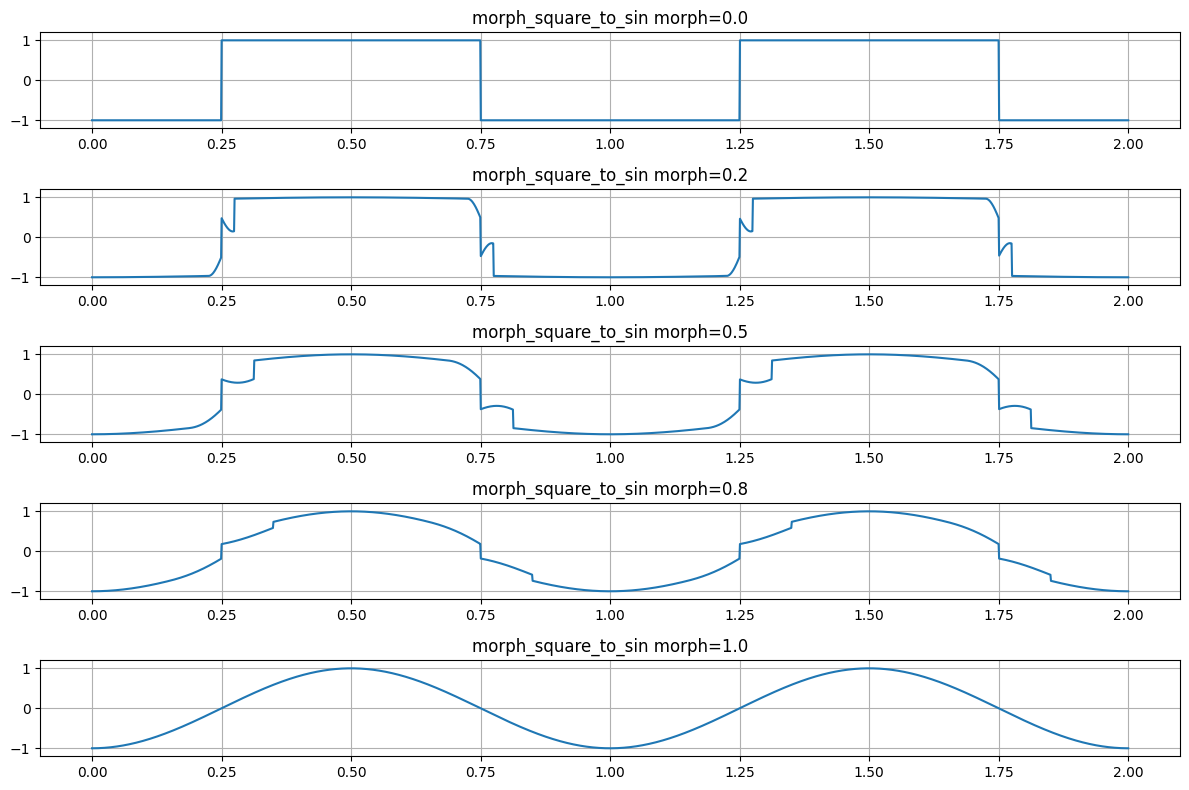

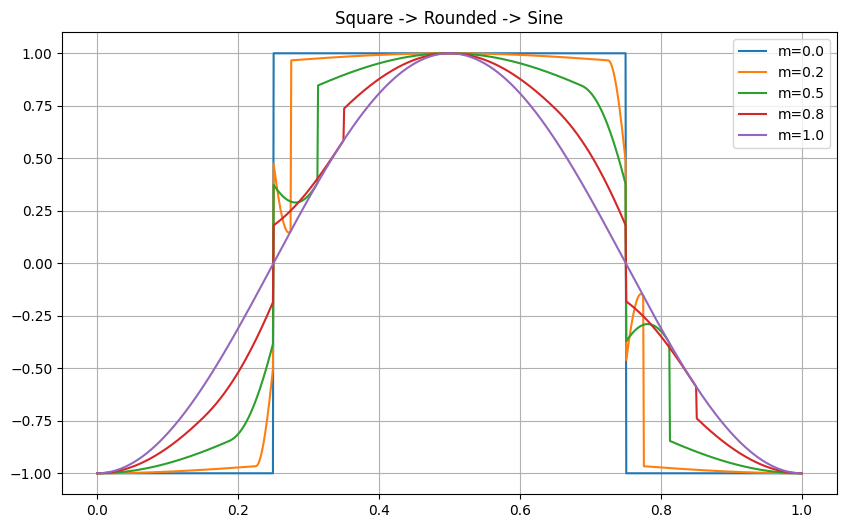

morph=0.0 -> [-1. -1.  1.  1.  1.  1. -1. -1.]
morph=0.2 -> [-1.    -0.988  0.48   0.988  1.     0.988 -0.48  -0.988]
morph=0.5 -> [-1.    -0.927  0.375  0.927  1.     0.927 -0.375 -0.927]
morph=0.8 -> [-1.    -0.813  0.18   0.813  1.     0.813 -0.18  -0.813]
morph=1.0 -> [-1.    -0.707 -0.     0.707  1.     0.707  0.    -0.707]


In [27]:
# 新しいモーフ: square -> rounded -> sine
def morph_square_to_sin(t, morph, freq=1.0, corner_width=0.25):
    """
    Morph from square (morph=0) to sine (morph=1) by progressively rounding square corners.

    Approach:
      - Define base square: +1 for phase in [0.25,0.75), else -1
      - Around each edge (phase at 0.25 and 0.75) define a transition window whose width
        shrinks as morph->0 and widens as morph->1 to smoothly interpolate to sine-like slope.
      - Use a smoothstep (cubic) to blend between flat and sine in the window.

    Parameters:
      - t: time array
      - morph: 0..1 (0 square, 1 sine)
      - freq: cycles per unit t
      - corner_width: maximum half-width of corner smoothing (fraction of period)

    Lightweight and vectorized for numpy. For MCU, see the integer-friendly variant below.
    """
    # normalize phase
    phase = (t * freq) - np.floor(t * freq)

    # base -cos (target sine)
    sine = -np.cos(2 * np.pi * t * freq)

    # square base
    square = np.where((phase >= 0.25) & (phase < 0.75), 1.0, -1.0)

    # corner smoothing width scales with morph: at morph=0 width=0 (sharp), morph=1 max width
    w = corner_width * morph
    # transition centers at edges 0.25 and 0.75
    edges = [0.25, 0.75]

    out = square.copy()

    def smoothstep(x):
        # cubic smoothstep: 3x^2 - 2x^3
        return 3*x*x - 2*x*x*x

    for e in edges:
        # compute distance from the edge in signed sense
        d = (phase - e + 0.5) % 1.0 - 0.5  # range -0.5..0.5, zero at edge
        # within half-width w/2 we blend
        hw = w / 2.0
        if hw <= 0:
            continue
        mask = np.abs(d) <= hw
        x = (d[mask] + hw) / (2*hw)  # 0..1 across the window
        s = smoothstep(x)
        # target is sine in the window
        out[mask] = (1.0 - s) * square[mask] + s * sine[mask]

    # for large morph the waveform approximates sine; ensure smooth interpolation to sine
    # final blend with sine based on morph^2 to favor square at small morph
    blend = morph*morph
    return (1.0 - blend) * out + blend * sine

# MCU-friendly variant using integer ops and simple lerp
import math

def morph_square_to_sin_mcu(phase, morph, freq=1.0, max_hw_n=25):
    """
    MCU single-sample version. phase in [0,1). morph scalar 0..1.
    max_hw_n: maximum half-window in integer-phase-steps (e.g., for 256 steps, use <=128).

    Approach:
      - Compute base square and sine (math.cos)
      - Compute half-width in steps: hw = int(round(morph * max_hw_n))
      - If within hw around either edge (0.25 or 0.75), perform simple linear interpolation
        between square and sine based on position in window.
      - Else output square. Finally, apply a small global blend morph^2 toward sine.
    """
    # get base values
    s = -math.cos(2.0 * math.pi * phase)
    square = 1.0 if (0.25 <= phase < 0.75) else -1.0

    if morph <= 0.0:
        return square
    if morph >= 1.0:
        return s

    # map phase to 0..N-1 integer for window tests (use N=256 for example)
    N = 256
    p_i = int((phase % 1.0) * N)
    hw = int(round(morph * max_hw_n))
    # edge positions in indices
    e1 = int(0.25 * N)
    e2 = int(0.75 * N)

    def in_window(pi, ei, hw):
        return abs((pi - ei + N//2) % N - N//2) <= hw

    val = square
    if in_window(p_i, e1, hw):
        dist = ((p_i - e1 + N) % N)
        if dist > N/2:
            dist -= N
        x = (dist + hw) / (2*hw)  # 0..1
        # linear blend
        val = (1.0 - x) * square + x * s
    elif in_window(p_i, e2, hw):
        dist = ((p_i - e2 + N) % N)
        if dist > N/2:
            dist -= N
        x = (dist + hw) / (2*hw)
        val = (1.0 - x) * square + x * s

    # global blend to sine
    blend = morph*morph
    return (1.0 - blend) * val + blend * s

# プロットで確認
fs = 1000
t = np.linspace(0, 2, fs*2)
vals = [0.0, 0.2, 0.5, 0.8, 1.0]
plt.figure(figsize=(12, 8))
for i, m in enumerate(vals):
    y = morph_square_to_sin(t, m)
    plt.subplot(len(vals), 1, i+1)
    plt.plot(t, y)
    plt.title(f'morph_square_to_sin morph={m}')
    plt.ylim(-1.2, 1.2)
    plt.grid(True)
plt.tight_layout()
plt.show()

# 1周期重ね表示
t1 = np.linspace(0, 1, fs)
plt.figure(figsize=(10,6))
for m in vals:
    plt.plot(t1, morph_square_to_sin(t1, m), label=f'm={m}')
plt.legend()
plt.title('Square -> Rounded -> Sine')
plt.grid(True)
plt.show()

# サンプル出力
for m in vals:
    t_check = np.array([0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875])
    print(f'morph={m} ->', np.round(morph_square_to_sin(t_check, m), 3))